In [1]:
import os
import PIL
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pydicom
import cv2

/home/rodrigo/miniconda3/envs/pydicomenv/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
img_size = (224, 224)
min_slices = 28
normalize_img = 1
# three_channels = 1
channel_windows = ((0, 80), (-1000, 2000), (150, 200))

# Prepare Training Data

In [8]:
def read_serie_paths(chosen_scans):
    f = open(chosen_scans, "r")
    serie_list = []
    for serie_path in f.readlines():
        serie_path = serie_path.strip("\n")
        serie_list.append(serie_path)
    return serie_list

def read_labels(labels_file):
    csv = np.loadtxt(labels_file, delimiter=",", dtype=str)[1:]
    return csv

# TODO: save middle slices
def save_slices(serie_list, labels):
    for label in labels:
        exam_number = label[0]
        find = "/" + exam_number + "/"
        try:
            serie_path = next(serie for serie in serie_list if find in serie)
            exam_path = serie_path.split(exam_number)[0] + exam_number
            save_slices_labels(exam_number, exam_path, label)
            save_slices_numpy(exam_number, exam_path, serie_path)
        except:
            pass
        print(serie_path)
        

def save_slices_labels(exam_number, exam_path, label):
    labels_path = exam_path + "/labels/"
    os.makedirs(labels_path, exist_ok=True)
    if '1' in label[1:]: # com hemorragia
        label_info = {'exam_id': exam_number, 'label': True}
    else: # sem hemorragia
        label_info = {'exam_id': exam_number, 'label': False}
    for slice_number in range(28):
        img_label_filename = labels_path + 'scan_' + exam_number + '_slice_' + str(slice_number) + '.npy'
        np.save(img_label_filename, label_info)
            
def save_slices_numpy(exam_number, exam_path, serie_path):
    # create dir to store numpy image data
    labels_path = exam_path + "/numpy/"
    os.makedirs(labels_path, exist_ok=True)
    
    # first get middle 28 slices
    num_slices = len(os.listdir(serie_path))
    start_slice = 0; end_slice = 28
    if num_slices > 28:
        middle = int(num_slices/2)
        start_slice = middle - 14
        end_slice = middle + 14
    
    #now we generate data for slices in the range between start_slice and end_slice
    for slice_index in range(start_slice, end_slice):
        # Choose Between RGB or Windowed slices
        slice_path = exam_path + "/pngs/CT" + str(slice_index) + ".png"
        if normalize_img == 1: #normalize to 0~255
            slice_img = cv2.imread(slice_path)
            img_processed = 255 * (slice_img - np.amin(slice_img)) / (np.amax(slice_img) - np.amin(slice_img))      
        else:
            # TODO: this is not working right
            if three_channels == 1:
                slice_img = cv2.imread(slice_path, cv2.COLOR_BGR2GRAY)
                #first create an empty numpy array for the channeled ones
                img_processed = np.empty((img_size[0], img_size[1], len(channel_windows)))
                for c in range(0, len(channel_windows)):
                    img_processed[:, :, c] = create_channel(slice_img, channel_windows[c][0], channel_windows[c][1])        
            else:
                img_processed = slice_img
        #save this img_processed as a numpy array
        img_file_name = exam_path + '/numpy/' + 'scan_' + exam_number + '_slice' + str(slice_index) + '.npy'
        np.save(img_file_name, img_processed)
    
def create_channel(data, level, width):
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)

In [9]:
root_dir = "/home/rodrigo/processed-dataset/"
chosen_scans = root_dir + "GoodDirs.txt"
labels_file = root_dir + "labels-merged.csv"

serie_list = read_serie_paths(chosen_scans)
labels = read_labels(labels_file)
save_slices(serie_list, labels)

/home/rodrigo/processed-dataset/0/dicoms/CT_Plain
/home/rodrigo/processed-dataset/1/dicoms/CT_2.55mm
/home/rodrigo/processed-dataset/2/dicoms/CT_5mm
/home/rodrigo/processed-dataset/3/dicoms/CT_Plain
/home/rodrigo/processed-dataset/4/dicoms/CT_5mm
/home/rodrigo/processed-dataset/4/dicoms/CT_5mm
/home/rodrigo/processed-dataset/4/dicoms/CT_5mm
/home/rodrigo/processed-dataset/7/dicoms/CT_Plain
/home/rodrigo/processed-dataset/7/dicoms/CT_Plain
/home/rodrigo/processed-dataset/9/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/9/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/11/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/12/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/13/dicoms/CT_PRE_CONTRAST_5MM_STD
/home/rodrigo/processed-dataset/13/dicoms/CT_PRE_CONTRAST_5MM_STD
/home/rodrigo/processed-dataset/15/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/15/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/17/dicoms/CT_5mm
/home/rodrigo/processed-dataset/18/dicoms/

/home/rodrigo/processed-dataset/145/dicoms/CT_Plain
/home/rodrigo/processed-dataset/146/dicoms/CT_PRE_CONTRAST_5MM_STD
/home/rodrigo/processed-dataset/147/dicoms/CT_2.55mm
/home/rodrigo/processed-dataset/148/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/149/dicoms/CT_5mm-2
/home/rodrigo/processed-dataset/150/dicoms/CT_55mm_Contrast
/home/rodrigo/processed-dataset/150/dicoms/CT_55mm_Contrast
/home/rodrigo/processed-dataset/152/dicoms/CT_Plain
/home/rodrigo/processed-dataset/152/dicoms/CT_Plain
/home/rodrigo/processed-dataset/154/dicoms/CT_Plain
/home/rodrigo/processed-dataset/155/dicoms/CT_5mm
/home/rodrigo/processed-dataset/156/dicoms/CT_Plain
/home/rodrigo/processed-dataset/156/dicoms/CT_Plain
/home/rodrigo/processed-dataset/156/dicoms/CT_Plain
/home/rodrigo/processed-dataset/159/dicoms/CT_5mm-2
/home/rodrigo/processed-dataset/160/dicoms/CT_Plain
/home/rodrigo/processed-dataset/160/dicoms/CT_Plain
/home/rodrigo/processed-dataset/162/dicoms/CT_Plain
/home/rodrigo/processed-datas

/home/rodrigo/processed-dataset/292/dicoms/CT_C
/home/rodrigo/processed-dataset/293/dicoms/CT_Plain
/home/rodrigo/processed-dataset/294/dicoms/CT_Plain
/home/rodrigo/processed-dataset/294/dicoms/CT_Plain
/home/rodrigo/processed-dataset/296/dicoms/CT_Plain
/home/rodrigo/processed-dataset/297/dicoms/CT_2.55mm
/home/rodrigo/processed-dataset/297/dicoms/CT_2.55mm
/home/rodrigo/processed-dataset/299/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/300/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/301/dicoms/CT_Plain
/home/rodrigo/processed-dataset/302/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/303/dicoms/CT_PRE_CONTRAST_5MM_STD
/home/rodrigo/processed-dataset/303/dicoms/CT_PRE_CONTRAST_5MM_STD
/home/rodrigo/processed-dataset/305/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/305/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/307/dicoms/CT_Plain
/home/rodrigo/processed-dataset/308/dicoms/CT_Plain
/home/rodrigo/processed-dataset/309/dicoms/CT_Plain
/home/rodri

/home/rodrigo/processed-dataset/442/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/443/dicoms/CT_PRE_CONTRAST_5MM_STD
/home/rodrigo/processed-dataset/444/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/444/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/446/dicoms/CT_Plain
/home/rodrigo/processed-dataset/447/dicoms/CT_BRAIN_PLAIN
/home/rodrigo/processed-dataset/447/dicoms/CT_BRAIN_PLAIN
/home/rodrigo/processed-dataset/449/dicoms/CT_5mm-2
/home/rodrigo/processed-dataset/450/dicoms/CT_Plain
/home/rodrigo/processed-dataset/451/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/452/dicoms/CT_Plain
/home/rodrigo/processed-dataset/453/dicoms/CT_Plain
/home/rodrigo/processed-dataset/454/dicoms/CT_5mm
/home/rodrigo/processed-dataset/454/dicoms/CT_5mm
/home/rodrigo/processed-dataset/456/dicoms/CT_5mm-2
/home/rodrigo/processed-dataset/457/dicoms/CT_2.55mm
/home/rodrigo/processed-dataset/458/dicoms/CT_55mm_Plain
/home/rodrigo/processed-dataset/459/dicoms/CT_Plain
/home/rodrigo/p

# IGNORE TESTS BELOW

(224, 224, 3)
(512, 512)
ok
(512, 512, 3)


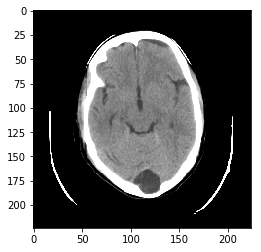

In [38]:
png_fn = '/home/rodrigo/Batch/0/pngs/CT11.png'
image = cv2.imread(png_fn)
print(image.shape)
imgplot = plt.imshow(image, cmap=plt.cm.bone)

dcm_fn = '/home/rodrigo/Batch/nifti/test-CT000000.dcm'
dataset = pydicom.dcmread(dcm_fn)
print(dataset.pixel_array.shape)
print("ok")

scan_fn = '/home/rodrigo/Batch/nifti/CQ500CT0_PLAIN_THIN.nii.gz'
img = nib.load(scan_fn)
img_data = img.get_data()
num_slice = img_data.shape[2]
print(img_data.shape)

# plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
# plt.show()

# Test Windowing

In [197]:
def get_lut(data, level, width):
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)


def create_channel(img, channel_min, channel_max):
    #this function will create channeled data based on the original single values data
    
    img_channel = img.copy()
    img_channel[img_channel <= channel_min] = 0
    img_channel[img_channel >= channel_max] = channel_max
    img_channel = 255 * (img_channel-np.amin(img_channel))/(np.amax(img_channel) - np.amin(img_channel))
    return img_channel

png_fn = '/home/rodrigo/Batch/0/pngs/CT11.png'
# image = cv2.imread(png_fn)
image = dataset.pixel_array
print(image.shape)
imgplot = plt.imshow(image, cmap=plt.cm.bone)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rodrigo/Batch/0/dicoms/CT11.dcm'

(512, 512, 3)


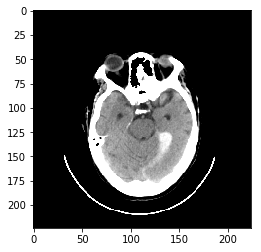

In [211]:
png_fn = '/home/rodrigo/Batch/159/pngs/CT11.png'
# image = cv2.imread(png_fn, cv2.COLOR_BGR2GRAY)
image = cv2.imread(png_fn)

# WINDOWING VALUES
#brain window: (l = 40, w = 80), i.e. 0~80 (everything <0 is 0, everything >80 is 255)
#bone window: (l = 500, w = 3000), i.e. -1000~2000
#subdural window: (l = 175, w = 50), i.e. 150~200

channel_param = ((0, 80), (-1000, 2000), (150, 200))
print(img.shape)
plt.imshow(image, cmap=plt.cm.bone)

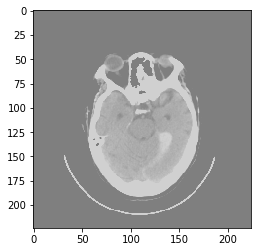

In [285]:
a = 1
b = 800
window = get_lut(image, a, b)
imgplot = plt.imshow(window)

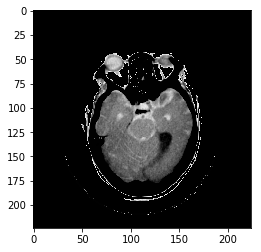

In [282]:
# pegar maior contorno e fazer alguma operação pra recuperar a hemorragia?
a = 1
b = 800
window = create_channel(image, a, b)
imgplot = plt.imshow(window)

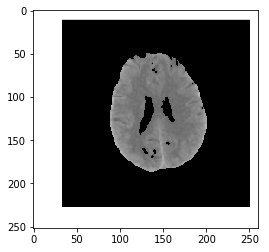

In [288]:
img3 = '/home/rodrigo/Videos/download (3).png'
image3= cv2.imread(img3)

plt.imshow(image3)